In [ ]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [ ]:
file_path = '/content/drive/MyDrive/Osun, Nigeria Chapter/01- Improving Food Security and Crop Yield in Nigeria through Machine Learning/Offical Project Folder/Data/Crop Disease/rice_leaf_diseases'

In [ ]:
name_class = os.listdir(file_path)
name_class

['Leaf smut', 'Bacterial leaf blight', 'Brown spot']

In [ ]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,"/content/drive/MyDrive/Osun, Nigeria Chapter/0...",Leaf smut
1,"/content/drive/MyDrive/Osun, Nigeria Chapter/0...",Bacterial leaf blight
2,"/content/drive/MyDrive/Osun, Nigeria Chapter/0...",Brown spot
3,"/content/drive/MyDrive/Osun, Nigeria Chapter/0...",Bacterial leaf blight
4,"/content/drive/MyDrive/Osun, Nigeria Chapter/0...",Brown spot


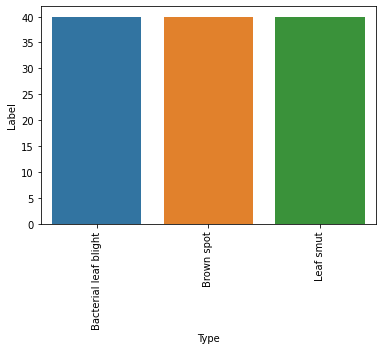

In [ ]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [ ]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

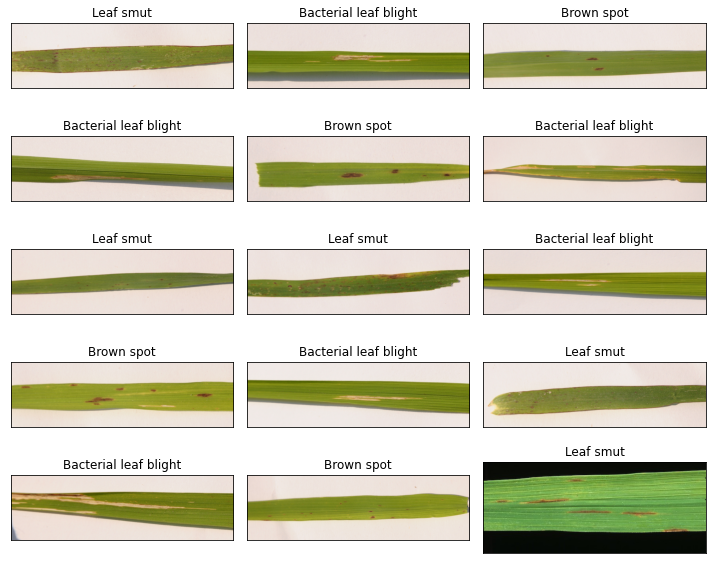

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [16]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 90 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.


In [17]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [18]:
inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [21]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

Epoch 1/10
3/3 [==============================] - 17s 5s/step - loss: 1.2093 - accuracy: 0.4778 - val_loss: 0.4803 - val_accuracy: 0.7667
Epoch 2/10
3/3 [==============================] - 11s 4s/step - loss: 0.5436 - accuracy: 0.8222 - val_loss: 0.2743 - val_accuracy: 0.9111
Epoch 3/10
3/3 [==============================] - 11s 4s/step - loss: 0.2910 - accuracy: 0.9111 - val_loss: 0.2075 - val_accuracy: 0.9222
Epoch 4/10
3/3 [==============================] - 11s 4s/step - loss: 0.1364 - accuracy: 0.9778 - val_loss: 0.0546 - val_accuracy: 0.9889
Epoch 5/10
3/3 [==============================] - 11s 4s/step - loss: 0.1166 - accuracy: 0.9444 - val_loss: 0.0720 - val_accuracy: 0.9778
Epoch 6/10
3/3 [==============================] - 11s 4s/step - loss: 0.0418 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 11s 4s/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 8/10
3/3 [==================

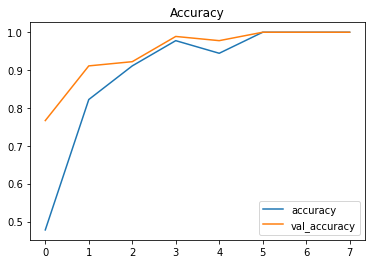

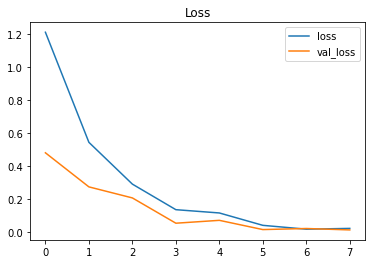

In [22]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [23]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06133
Test Accuracy: 96.67%


In [24]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [25]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         7
           Brown spot       0.93      1.00      0.97        14
            Leaf smut       1.00      0.89      0.94         9

             accuracy                           0.97        30
            macro avg       0.98      0.96      0.97        30
         weighted avg       0.97      0.97      0.97        30

